# Open Quantum Transverse-Field Ising Model (TFIM) with Bulk Dephasing

This notebook simulate an *open quantum system* using **NetKet**.

We study a one-dimensional spin-½ **Transverse-Field Ising Model (TFIM)** subject to **bulk dephasing**.

The system evolves according to a **Lindblad master equation**, and we use a **Neural Density Matrix (NDM)** 
variational ansatz to approximate its *steady state*.

We will:
1. Build the TFIM Hamiltonian.
2. Define the dissipators (jump operators).
3. Construct the Liouvillian.
4. Optimize the steady state with `SteadyState` driver.
5. Compare with the exact steady-state solution for small system sizes.


In [1]:
import netket as nk
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

N         = 4                  # number of spins (keep small if you want exact check)
Jzz       = 1.0                # Ising zz coupling
Gamma     = 0.5                # transverse field (x)
hz        = 0.0                # optional longitudinal field
gamma_phi = 0.2                # bulk dephasing rate

c:\Users\maxim\anaconda3\envs\nqs311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Building the System Hamiltonian

We construct the **Transverse-Field Ising Model (TFIM)** Hamiltonian:

$$
H = -J_{zz} \sum_i \sigma_i^z \sigma_{i+1}^z - \Gamma \sum_i \sigma_i^x.
$$

- The first term couples neighboring spins along the z-axis (Ising interaction).  
- The second term applies a transverse magnetic field along the x-axis.  

We use **open boundary conditions** for simplicity (no periodic wrap-around).


In [2]:
hi = nk.hilbert.Spin(s=1/2, N=N)

# TFIM:  H = -J Σ σ^z_i σ^z_{i+1} - Γ Σ σ^x_i - h Σ σ^z_i  (PBC optional; here OBC for simplicity)
H = nk.operator.LocalOperator(hi)

# σ^z σ^z nearest-neighbor (open chain; use (i+1)%N for PBC)
for i in range(N-1):
    H += -Jzz * (nk.operator.spin.sigmaz(hi, i) @ nk.operator.spin.sigmaz(hi, i+1))

# transverse field
for i in range(N):
    H += -Gamma * nk.operator.spin.sigmax(hi, i)


print("Hamiltonian built with TFIM + fields.")
print(H)

Hamiltonian built with TFIM + fields.
LocalOperatorJax(dim=4, #acting_on=7 locations, constant=0.0, dtype=float64)


## 2. Defining the Liouvillian (Open Quantum System)

To describe an *open* system interacting with an environment, we use the **Lindblad master equation**:

$$
\dot{\rho} = \mathcal{L}(\rho)
= -i[H, \rho] + \sum_i \left( L_i \rho L_i^\dagger
- \frac{1}{2}\{L_i^\dagger L_i, \rho\} \right),
$$

where $ L_i $ are the jump operators representing the interaction with the environment.

Here we model **pure dephasing** on each spin:

$$
L_i = \sqrt{\gamma_\phi}\,\sigma_i^z.
$$

This type of noise destroys quantum coherence in the z-basis but preserves populations.


In [3]:
jumps = [jnp.sqrt(gamma_phi) * nk.operator.spin.sigmaz(hi, i) for i in range(N)]
L = nk.operator.LocalLiouvillian(H, jumps)
print("Lindbladian (TFIM + bulk dephasing):")
print(L)

Lindbladian (TFIM + bulk dephasing):
LocalLiouvillian(hilbert=DoubledHilbert(Spin(s=1/2, N=4, ordering=new)), dtype=complex128)


## 3. Neural Density Matrix Ansatz (NDM)

We represent the density matrix $ \rho_\theta $ using the **Neural Density Matrix (NDM)** ansatz.

The NDM:
- Guarantees that $ \rho_\theta $ is *positive semidefinite* and *Hermitian*.
- Can be trained via stochastic optimization.
- Lives on a **doubled Hilbert space**, where the left and right spin configurations are treated separately.

Sampling is performed with:
- A **MetropolisLocal** sampler on the doubled space (off-diagonal elements).
- A second sampler restricted to the physical Hilbert space (for diagonal terms).


In [4]:
model = nk.models.NDM(alpha=2)

dh = nk.hilbert.DoubledHilbert(hi)
sampler_off = nk.sampler.MetropolisLocal(dh, n_chains=128)
sampler_diag = nk.sampler.MetropolisLocal(hi, n_chains=128)

vstate = nk.vqs.MCMixedState(
    sampler_off,
    model,
    sampler_diag=sampler_diag,
    n_samples=512,
    n_samples_diag=2048,
    seed=123,
)

## 4. Optimization Setup

We use the **SteadyState** driver to find the variational steady state $ \rho_\theta^\ast $
that minimizes the loss:

$$
\mathcal{L} = \langle \rho_\theta | \mathcal{L}^\dagger \mathcal{L} | \rho_\theta \rangle.
$$

This quantity is zero only if $ \mathcal{L}(\rho_\theta) = 0 $, i.e., the steady-state condition.

Training details:
- **Adam optimizer** for parameter updates.
- **Stochastic Reconfiguration (SR)** as a natural gradient preconditioner.
- Learning rate (`lr`) and SR regularization (`diag_shift`) are reduced progressively across three training phases.


In [5]:
opti = nk.optimizer.Adam(learning_rate=3e-3)
sr   = nk.optimizer.SR(diag_shift=5e-3)

driver = nk.driver.SteadyState(
    lindbladian=L,
    variational_state=vstate,
    optimizer=opti,
    preconditioner=sr,
)

log = nk.logging.RuntimeLog()

for phase, (iters, lr, shift) in enumerate([(1000, 3e-3, 5e-3),
                                            (500, 1.5e-3, 2.5e-3),
                                            ]):

    opti.learning_rate = lr
    sr.diag_shift = shift
    print(f"\nPhase {phase+1}: lr={lr}, shift={shift}")
    driver.run(n_iter=iters, out=log)




Phase 1: lr=0.003, shift=0.005


100%|██████████| 1000/1000 [01:28<00:00, 11.25it/s, LdagL=0.0405 ± 0.0086 [σ²=2.9e-02, R̂=1.180]]



Phase 2: lr=0.0015, shift=0.0025


100%|██████████| 500/500 [00:41<00:00, 12.12it/s, LdagL=0.0192 ± 0.0041 [σ²=7.7e-03, R̂=1.137]]


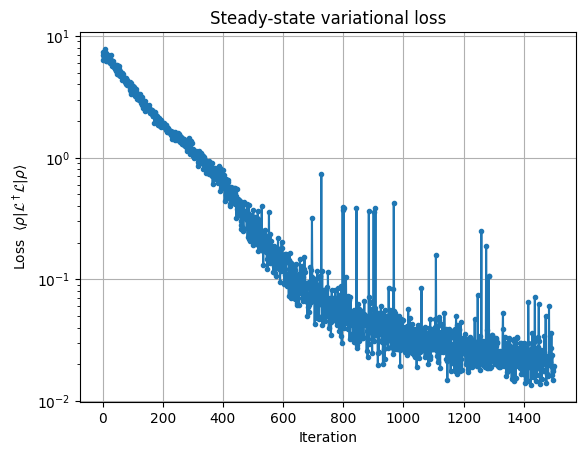

In [6]:
def _extract_series(log, key):
    x = log.data[key]
    if isinstance(x, dict):
        for k in ("Mean","mean","Value","value"):
            if k in x:
                return np.asarray(x[k], dtype=float)
        return np.asarray(list(x.values()), dtype=float)
    return np.asarray(x, dtype=float)

if "LdagL" in log.data:
    iters  = np.arange(len(_extract_series(log, "LdagL")))
    losses = _extract_series(log, "LdagL")

    plt.figure()
    plt.semilogy(iters, losses, "-o", ms=3)
    plt.xlabel("Iteration")
    plt.ylabel(r"Loss  $\langle\rho|{\cal L}^\dagger{\cal L}|\rho\rangle$")
    plt.title("Steady-state variational loss")
    plt.grid(True)

    plt.show()

## 5. Exact vs Variational Checks (Small N)

For small system sizes $ N $, we can explicitly compute the exact steady state $ \rho_{\text{ex}} $ by solving

$$
\mathcal{L}\,\mathrm{vec}(\rho_{\text{ex}}) = 0
$$

using sparse linear algebra solvers on the Liouvillian superoperator.

We then compare the variational results obtained with the NDM ansatz to these exact steady-state expectations.

### Quantities Compared
- **Energy density:**  
  $$
  \langle H \rangle / N = \frac{1}{N}\,\mathrm{Tr}(\rho\,H)
  $$
- **Local magnetizations:**  
  $$
  \langle \sigma_i^x \rangle,\quad \langle \sigma_i^z \rangle
  $$



In [7]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# --- Exact steady state with SciPy (sparse) ------------------------------
def steady_state_sparse(L, N, prefer='svd'):
    """
    Find rho_ss s.t. L vec(rho_ss) = 0 using sparse SciPy solvers.
    L: NetKet Lindbladian (nk.operator.LocalLiouvillian or similar)
    N: Hilbert dimension (not #spins)  -> rho will be NxN
    prefer: 'svd' (recommended) or 'eigs'
    """
    # Get sparse superoperator in column-stacking (NetKet uses vec(.) convention)
    Lsp = L.to_sparse()  # (N^2) x (N^2) csr_matrix

    # ---- A) via smallest singular vector of L  (robust to non-normal L) ----
    if prefer == 'svd':
        try:
            # Find the singular vector with the *smallest* singular value
            # (needs SciPy >= 1.7; if not available, it'll raise and we’ll fallback)
            u, s, vt = spla.svds(Lsp, k=1, which='SM')
            v0 = vt[0]                  # right singular vector (shape N^2,)
        except Exception:
            prefer = 'eigs'             # fallback if 'SM' not supported

    # ---- B) via eigenvector with eigenvalue closest to 0 (shift-invert) ----
    if prefer == 'eigs':
        # Shift-invert at sigma=0 targets eigenvalues near 0 as 'largest magnitude'
        # This performs an LU factorization internally; OK for moderate sizes.
        v0 = spla.eigs(Lsp, k=1, sigma=0.0, which='LM')[1][:, 0]

    # reshape to matrix, make physical
    rho = v0.reshape(N, N)

    # Hermitize (remove tiny anti-Hermitian numerical parts)
    rho = 0.5 * (rho + rho.conj().T)

    # PSD clip (project onto positive semidefinite cone)
    w, V = np.linalg.eigh(rho)
    w = np.clip(w.real, 0.0, None)
    if w.sum() == 0:
        # null projection would happen only in pathological cases; fall back to I/N
        rho = np.eye(N) / N
    else:
        rho = (V @ np.diag(w) @ V.conj().T) / w.sum()

    # Normalize trace exactly
    rho = rho / np.trace(rho)

    # Optional: check residual ||L vec(rho)||_2
    res = np.linalg.norm(Lsp @ rho.reshape(-1), ord=2)
    return rho, res

# --- Exact ⟨O⟩ and VMC ⟨O⟩ wrappers -------------------------------------
def exact_expect(op, rho):
    """Exact ⟨O⟩ = Tr(ρ O). Works with dense or sparse op."""
    if hasattr(op, "to_sparse"):
        opM = op.to_sparse()
        if sp.issparse(opM):
            return float((opM @ rho).diagonal().sum().real)
    opM = op.to_dense() if hasattr(op, "to_dense") else op
    return float(np.trace(rho @ opM).real)

def vmc_expect(op, vstate):
    est = vstate.expect(op)
    mean = float(est.mean.real)
    err  = float(getattr(est, "error_of_mean", 0.0))
    return mean, err



In [8]:
# --- Compare VMC vs Exact: energy and local mags -------------------------
Nspins = hi.size
dim    = hi.n_states

# Exact steady state
rho_ex, residual = steady_state_sparse(L, dim, prefer='svd')
print(f"||L vec(ρ_ss)||₂ = {residual:.3e} | Tr(ρ)= {np.trace(rho_ex).real:.6f}")

# Exact expectations
from netket.operator.spin import sigmax, sigmaz

mx_ex = [exact_expect(sigmax(hi,i), rho_ex) for i in range(Nspins)]
mz_ex = [exact_expect(sigmaz(hi,i), rho_ex) for i in range(Nspins)]
E_ex  = exact_expect(H, rho_ex) / Nspins

# VMC expectations
mx_vmc, mx_err, mz_vmc, mz_err = [], [], [], []
for i in range(Nspins):
    m, e = vmc_expect(sigmax(hi,i), vstate)
    mx_vmc.append(m); mx_err.append(e)
    m, e = vmc_expect(sigmaz(hi,i), vstate)
    mz_vmc.append(m); mz_err.append(e)

E_vmc, E_err = vmc_expect(H, vstate)
E_vmc /= Nspins

# Print comparison
print("\nEnergy density  ⟨H⟩/L")
print(f"VMC: {E_vmc:+.6f}  ± {E_err:.3g}    |   Exact: {E_ex:+.6f}")

print("\n⟨σx_i⟩   (VMC ± err)            [Exact]")
for i in range(Nspins):
    print(f"i={i}: {mx_vmc[i]:+.6f} ± {mx_err[i]:.3g}    [{mx_ex[i]:+.6f}]")

print("\n⟨σz_i⟩   (VMC ± err)            [Exact]")
for i in range(Nspins):
    print(f"i={i}: {mz_vmc[i]:+.6f} ± {mz_err[i]:.3g}    [{mz_ex[i]:+.6f}]")


||L vec(ρ_ss)||₂ = 1.388e-17 | Tr(ρ)= 1.000000

Energy density  ⟨H⟩/L
VMC: -0.611410  ± 0.0289    |   Exact: +0.000000

⟨σx_i⟩   (VMC ± err)            [Exact]
i=0: +0.338280 ± 0.00727    [+0.000000]
i=1: +0.275706 ± 0.00836    [+0.000000]
i=2: +0.267560 ± 0.0083    [+0.000000]
i=3: +0.306606 ± 0.00543    [+0.000000]

⟨σz_i⟩   (VMC ± err)            [Exact]
i=0: +0.000977 ± 0.0422    [+0.000000]
i=1: -0.004883 ± 0.0447    [+0.000000]
i=2: +0.001953 ± 0.0442    [+0.000000]
i=3: +0.020508 ± 0.0416    [+0.000000]


### Discussion

The obtained results are not fully convincing, as the variational estimates of observables do not quantitatively match the exact steady-state values.  
It remains unclear whether this discrepancy originates from statistical noise due to insufficient sampling or from an implementation issue.

Since no official NetKet tutorial currently documents the full workflow for open-system steady-state optimization with a Neural Density Matrix (NDM), some steps of the approach—particularly the setup of samplers and the steady-state driver—may have been misapplied or incomplete in this notebook.
